In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# taken from https://github.com/jrmontag/STLDecompose
# requires installation - pip install stldecompose
from stldecompose import decompose
# Simpler smoothing uses:
# from statsmodels.tsa.seasonal import seasonal_decompose

import geopandas as gpd

In [2]:
q = '''

SELECT
  p.dispenser_code,
  prac.ContractorName,
  prac.Area_,
  prac.AreaCode,
  p.year_month,
  SUM(IF(SUBSTR(p.bnf_code,1,13)='1001030U0AAAB',
      item_count,
      0)) AS mtx_2_5,
  SUM(IF(SUBSTR(p.bnf_code,1,13)='1001030U0AAAC',
      item_count,
      0)) AS mtx_10,
    SUM(IF((SUBSTR(p.bnf_code,1,12)='1001030U0AAB'
      OR SUBSTR(p.bnf_code,1,12)='1001030U0AAC'
      OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAZ'
      OR SUBSTR(p.bnf_code,1,8)='0801030P') AND (SUBSTR(p.bnf_code,1,13)!='1001030U0AACF'
      OR SUBSTR(p.bnf_code,1,13)!='1001030U0AABT'
      OR SUBSTR(p.bnf_code,1,13)!='1001030U0AABU'),
      item_count,
      0)) AS mtx_inj,
  SUM(item_count) AS total_mtxitems
  FROM
    ebmdatalab.brian.methotrexate_subset_dispensers_prescribing AS p
  INNER JOIN
    ebmdatalab.dispensers.dispensers AS prac
  ON
    p.dispenser_code = prac.contractorcode
  GROUP BY
  p.dispenser_code,
  prac.ContractorName,
  prac.Area_,
  prac.AreaCode,
  p.year_month'''

disp_mtx = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')

disp_mtx.info()

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas_gbq\gbq.py:556: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  "verbosity", FutureWarning, stacklevel=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326040 entries, 0 to 326039
Data columns (total 9 columns):
dispenser_code    326040 non-null object
ContractorName    326040 non-null object
Area_             326040 non-null object
AreaCode          326040 non-null object
year_month        326040 non-null object
mtx_2_5           326040 non-null int64
mtx_10            326040 non-null int64
mtx_inj           326040 non-null int64
total_mtxitems    326040 non-null int64
dtypes: int64(4), object(5)
memory usage: 22.4+ MB


In [17]:
pc = disp_mtx.copy()

pc["injections"] = 100*(pc.mtx_inj/pc.total_mtxitems).fillna(0)
pc["10mg measure"] = 100*(pc.mtx_10/(pc.mtx_10+pc.mtx_2_5)).fillna(0)

pd.options.display.max_rows = 1000
pc.loc[pc.year_month == '201711'].sort_values(by='10mg measure', ascending=False).head(1000)




,dispenser_code,ContractorName,Area_,AreaCode,year_month,mtx_2_5,mtx_10,mtx_inj,total_mtxitems,injections,10mg measure
203826,FEG29,ACHEASON DISPENSING CHEMIST,NORTH EAST LONDON,Q61,201711,0,3,0,3,0.000000,100.000000
224215,FJ365,ZAFASH LTD CHEMISTS,NORTH WEST LONDON,Q62,201711,0,4,0,4,0.000000,100.000000
225789,FLE65,PRINCE CHEMIST,NORTH WEST LONDON,Q62,201711,0,1,0,1,0.000000,100.000000
207561,FJ342,DOBBER PHARMACY (CHEMGRANGE LTD),NORTH EAST LONDON,Q61,201711,0,1,0,1,0.000000,100.000000
100028,FRQ71,THE CARE PHARMACY,WEST YORKSHIRE,Q52,201711,0,3,0,3,0.000000,100.000000
126943,FTJ90,WELL YARDLEY - CHURCH ROAD,BIRMINGHAM & THE BLACK COUNTRY,Q54,201711,0,1,0,1,0.000000,100.000000
124084,FP007,CARE PHARMACY,BIRMINGHAM & THE BLACK COUNTRY,Q54,201711,0,1,0,1,0.000000,100.000000
116906,FEH43,SPARKBROOK HEALTH CENTRE PHARMACY,BIRMINGHAM & THE BLACK COUNTRY,Q54,201711,0,1,0,1,0.000000,100.000000
246670,FTF05,LEWISHAM PHARMACY,SOUTH LONDON,Q63,201711,0,1,0,1,0.000000,100.000000
221722,FE354,SUMER PHARMACY,NORTH WEST LONDON,Q62,201711,0,1,0,1,0.000000,100.000000


In [4]:
pc.dispenser_code.drop_duplicates().count()

11689

# Calculations and Percentiles

In [5]:
x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))

#filtered tables grouped by months
pcf = pc.groupby('year_month').quantile(x)

#putting groupby(month) from index back into being a column
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf

,year_month,percentile,10mg measure,injections,mtx_10,mtx_2_5,mtx_inj,total_mtxitems
0,201507,0.10,0.000000,0.000000,0.00,3.00,0.0,4.0
1,201507,0.20,0.000000,0.000000,0.00,5.00,0.0,6.0
2,201507,0.30,0.000000,0.000000,0.00,7.00,0.0,8.0
3,201507,0.40,0.000000,0.000000,0.00,9.00,0.0,10.0
4,201507,0.50,0.000000,0.000000,0.00,11.00,0.0,12.0
5,201507,0.60,0.000000,0.000000,0.00,13.00,0.0,15.0
6,201507,0.70,0.000000,0.000000,0.00,16.00,0.0,18.0
7,201507,0.80,7.692308,5.000000,1.00,20.00,1.0,22.0
8,201507,0.90,20.000000,12.500000,2.00,26.00,2.0,28.0
9,201507,0.01,0.000000,0.000000,0.00,1.00,0.0,1.0


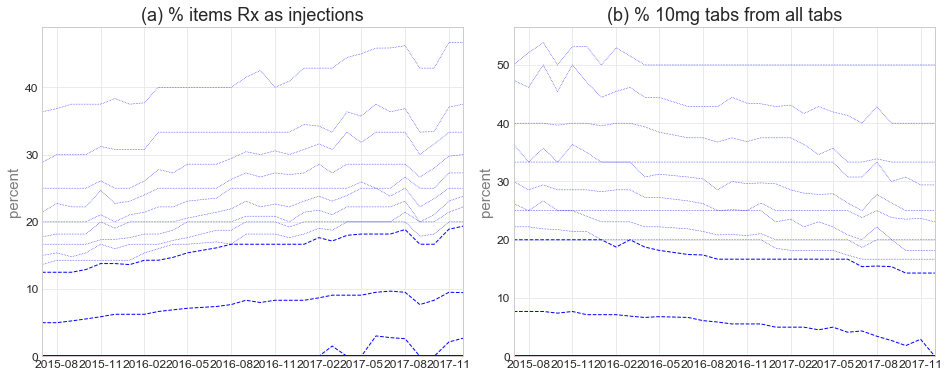

In [6]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["year_month"])#,"drug"])
dfp['year_month'] = dfp['year_month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y%m').date() for date in dfp['year_month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
# order is column, title, axis
s = [(0,'injections',0,0, '(a) % items Rx as injections', 'percent'),
    (1,'10mg measure',0,1, '(b) % 10mg tabs from all tabs', 'percent')]


x = pd.Series(x)
fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('disp_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021EA3BE8320>]],
      dtype=object)

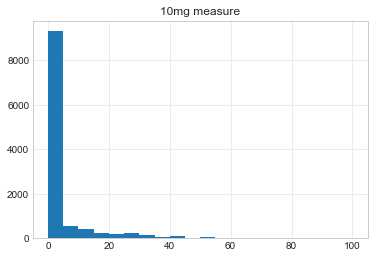

In [23]:
pc.loc[pc.year_month == '201711'].hist('10mg measure',bins=20)
